In [2]:
import pandas


score_file="../exp/result/results-2024-01-02-15-43-10/ASV-vctk_dev_enrolls_anon-vctk_dev_trials_f_anon/scores"
key_file="../corpora/test_utt_list_2/data/vctk_dev_trials_f/trials"

scr = pandas.read_csv(score_file, sep=' ', header=None).pivot_table(index=0, columns=1, values=2)
key = pandas.read_csv(key_file, sep=' ', header=None).replace('nontarget', False).replace('target', True).pivot_table(index=0, columns=1, values=2)


matedScores = scr.values[key.values == True]
nonMatedScores = scr.values[key.values == False]

In [5]:
scr

1,p234_025_mic2,p234_026_mic2,p234_027_mic2,p234_028_mic2,p234_029_mic2,p234_030_mic2,p234_031_mic2,p234_032_mic2,p234_033_mic2,p234_034_mic2,...,p249_038_mic2,p249_039_mic2,p249_040_mic2,p249_042_mic2,p249_043_mic2,p249_044_mic2,p249_045_mic2,p249_046_mic2,p249_047_mic2,p249_048_mic2
0,,,,,,,,,,,,,,,,,,,,,
p234,99.56207,85.98935,88.40260,97.66144,78.35569,122.08560,104.271200,116.58670,78.00538,119.15150,...,NaN,NaN,-56.34623,NaN,-91.30685,-94.88275,-57.39834,NaN,-105.92170,NaN
p238,-22.31960,NaN,-25.43522,NaN,-46.33429,NaN,-1.647774,-32.81435,NaN,NaN,...,-65.48495,-70.00436,NaN,-80.66644,NaN,-24.40256,NaN,-40.78621,-70.32894,-86.41521
p249,-73.92162,NaN,-77.56651,NaN,NaN,-55.74885,NaN,NaN,-68.13551,-82.12383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
import numpy as np

def linkability(matedScores, nonMatedScores, omega=1,nBins=-1):
    """Compute Linkability measure between mated
    and non-mated scores.

    Parameters
    ----------
    matedScores : Array_like
        List of scores associated to mated pairs
    nonMatedScores : Array_like
        List of scores associated to non-mated pairs
    omega : float
        Prior ration P[mated]/P[non-mated]

    Returns
    -------
    Dsys : float
        Global linkability measure.
    D : ndarray
        Local linkability measure for each bin.
    bin_centers : ndarray
        Center of the bins (from historgrams).
    bin_edges : ndarray
        Edges of the bis (from histograms)

    Notes
    -----
    Adaptation of the linkability measure of Gomez-Barrero et al. [1]

    References
    ----------

    .. [1] Gomez-Barrero, M., Galbally, J., Rathgeb, C. and Busch,
    C., 2017. General framework to evaluate unlinkability in biometric
    template protection systems. IEEE Transactions on Information
    Forensics and Security, 13(6), pp.1406-1420.
    """
    # Limiting the number of bins (100 maximum or lower if few scores available)
    if nBins < 0:
        nBins = min(int(len(matedScores) / 10), 100)

    # define range of scores to compute D
    bin_edges=np.linspace(min([min(matedScores), min(nonMatedScores)]),  max([max(matedScores), max(nonMatedScores)]), num=nBins + 1, endpoint=True)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    # compute score distributions using normalized histograms
    y1 = np.histogram(matedScores, bins = bin_edges, density = True)[0]
    y2 = np.histogram(nonMatedScores, bins = bin_edges, density = True)[0]
    # LR = P[s|mated ]/P[s|non-mated]
    LR = np.divide(y1, y2, out=np.ones_like(y1), where=y2!=0)
    # compute D
    D = 2*(omega*LR/(1 + omega*LR)) - 1
    # Def of D
    D[omega*LR <= 1] = 0
    # Taking care of inf/NaN
    mask =  [True if y2[i]==0 and y1[i]!=0 else False for i in range(len(y1))]
    D[mask] = 1
    # Global measure using trapz numerical integration
    Dsys = np.trapz(x = bin_centers, y = D* y1)
    return Dsys, D, bin_centers, bin_edges

Dsys, D, bin_centers, bin_edges  = linkability(matedScores, nonMatedScores, omega=1)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def draw_scores(matedScores, nonMatedScores, Dsys, D, bin_centers, bin_edges, output_file):
    """Draw both mated and non-mated score distributions
    and associated their associated local linkability

    Parameters
    ----------
    matedScores : Array_like
        list of scores associated to mated pairs
    nonMatedScores : Array_like
        list of scores associated to non-mated pairs
    Dsys : float
        Global linkability measure.
    D : ndarray
        Local linkability measure for each bin.
    bin_centers : ndarray
        Center of the bins (from historgrams).
    bin_edges : ndarray
        Edges of the bis (from histograms)
    output_file : String
        Path to png and pdf output file.

    References
    ----------

    .. [1] Gomez-Barrero, M., Galbally, J., Rathgeb, C., & Busch,
     C. (2017). General framework to evaluate unlinkability in
     biometric template protection systems. IEEE Transactions
     on Information Forensics and Security, 13(6), 1406-1420.
    """
    # Colorblind and photocopy friendly colors
    colors=['#e66101','#fdb863','#b2abd2','#5e3c99']
    legendLocation='upper left'
    plt.clf()
    # Kernel density estimate of the score
    ax = sns.kdeplot(matedScores, shade=False, label='Same Speaker', color=colors[2],linewidth=2, linestyle='--')
    x1,y1 = ax.get_lines()[0].get_data()
    ax = sns.kdeplot(nonMatedScores, shade=False, label='Not Same Speaker', color=colors[0],linewidth=2, linestyle=':')
    x2,y2 = ax.get_lines()[1].get_data()
    # Associated local linkability
    ax2 = ax.twinx()
    lns3, = ax2.plot(bin_centers, D, label='$\mathrm{D}_{\leftrightarrow}(s)$', color=colors[3],linewidth=2)

    # #print omega * LR = 1 lines
    index = np.where(D <= 0)
    ax.axvline(bin_centers[index[0][0]], color='k', linestyle='--')

    # Figure formatting
    ax.spines['top'].set_visible(False)
    ax.set_ylabel("Probability Density")
    ax.set_xlabel("Score")
    # Global Linkability
    ax.set_title("$\mathrm{D}_{\leftrightarrow}^{\mathit{sys}}$ = %.2f" % (Dsys),  y = 1.02)
    # Legends
    labs = [ax.get_lines()[0].get_label(), ax.get_lines()[1].get_label(), ax2.get_lines()[0].get_label()]
    lns = [ax.get_lines()[0], ax.get_lines()[1], lns3]
    ax.legend(lns, labs, loc = legendLocation)
    # Frame of Values
    ax.set_ylim([0, max(max(y1), max(y2)) * 1.05])
    ax.set_xlim([bin_edges[0]*0.98, bin_edges[-1]*1.02])
    ax2.set_ylim([0, 1.1])
    ax2.set_ylabel("$\mathrm{D}_{\leftrightarrow}(s)$")

    # Optional: getting rid of possible extensions
    outname= output_file.replace('.pdf', '').replace('.png', '').replace('.csv', '').replace('.txt', '')
    plt.savefig(outname + ".pdf", format="pdf")
    plt.savefig(outname + ".png", format="png")

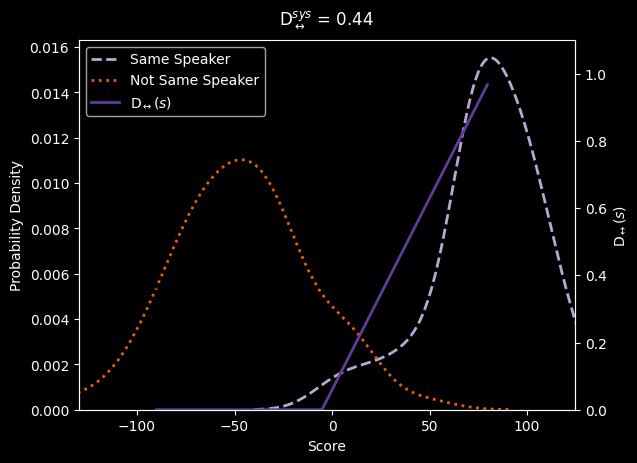

In [11]:
# draw scores
output_file = "../exp/result/results-2024-01-04-15-33-43/ASV-vctk_dev_enrolls-vctk_dev_trials_f/linkability"
draw_scores(matedScores, nonMatedScores, Dsys, D, bin_centers, bin_edges, output_file)
